# Modelo com Arquitetura 2 usando Data Augmentation

## Etapa 1 - Importando as bibliotecas

In [ ]:
#Importação das bibliotecas
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import zipfile

cv2.__version__

'3.4.3'

In [ ]:
#Importação tensorflow 
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__

TensorFlow 2.x selected.


'2.0.0'

## Etapa 2 - Conectando com o Drive e acessando os arquivos

In [ ]:
#Conectando com o google drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
#Carregamento dos arquivos necessários através do drive
path = "/content/gdrive/My Drive/Material.zip"
zip_object = zipfile.ZipFile(file=path, mode="r")
zip_object.extractall("./")
base_imgs = 'Material/fer2013.zip'
zip_object = zipfile.ZipFile(file = base_imgs, mode = "r")
zip_object.extractall("./")
zip_object.close()

## Etapa 3 - Acessando a base com fotos de expressões faciais



In [ ]:
#Carregamento base de dados
diretorio = 'gdrive/My Drive/Cursos/Deteccao_Expressoes_Faciais/';

data = pd.read_csv(diretorio+'fer2013/fer2013.csv')
data.tail()

,emotion,pixels,Usage
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest
35886,2,19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...,PrivateTest


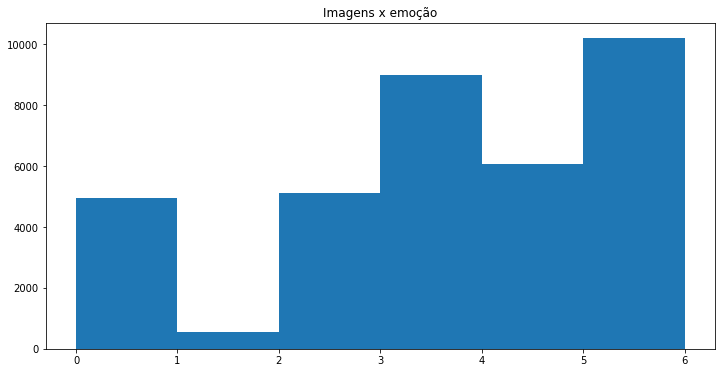

In [ ]:
#Plot das emoções presentes no dataset
plt.figure(figsize=(12,6))
plt.hist(data['emotion'], bins=6)
plt.title("Imagens x emoção")
plt.show()

# Classes: ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

## Etapa 4 - Pré-processamento

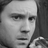

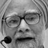

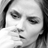

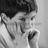

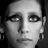

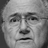

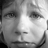

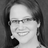

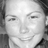

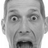

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [ ]:
#Pprocessa o conjunto de dados: transforma as strings de pixels em imagens
#Normaliza seus valores para o intervalo [0, 1] e converte as 

pixels = data['pixels'].tolist()
largura, altura = 48, 48

faces = []
amostras = 0
for pixel_sequence in pixels:
  face = [int(pixel) for pixel in pixel_sequence.split(' ')]
  face = np.asarray(face).reshape(largura, altura)
  faces.append(face)

  if (amostras < 10):
    cv2_imshow(face)

  amostras = amostras + 1

faces = np.asarray(faces)
faces = np.expand_dims(faces, -1)

def normalizar(x):
    x = x.astype('float32')
    x = x / 255.0
    return x

faces = normalizar(faces)

emocoes = pd.get_dummies(data['emotion']).as_matrix()

In [ ]:
print("Número total de imagens no dataset: "+str(len(faces)))

Número total de imagens no dataset: 35887


## Etapa 5 - Imports do Tensorflow/Keras

In [ ]:
#Importação para arquitetura de uma rede neural, compilação e treino
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json

## Etapa 6 - Dividir em conjuntos para treinamento e validação

In [ ]:
#Separação dos dados
x_train, x_test, y_train, y_test = train_test_split(faces, emocoes, test_size=0.1, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=41)

print("Número de imagens no conjunto de treinamento:", len(x_train))
print("Número de imagens no conjunto de testes:", len(x_test))
print("Número de imagens no conjunto de validação:", len(y_val))

Número de imagens no conjunto de treinamento: 29068
Número de imagens no conjunto de testes: 3589
Número de imagens no conjunto de validação: 3230


In [ ]:
#Salvando os dados de teste
np.save('mod_xtest', x_test)
np.save('mod_ytest', y_test)

## Etapa 7 - Arquitetura do Modelo (CNN)

### Arquitetura do modelo

Implementação original: https://github.com/rajeevratan84/DeepLearningCV/blob/master/18.2%20Building%20an%20Emotion%20Detector%20with%20LittleVGG.ipynb

## Teste com arquitetura 2

In [ ]:
#Criação da arquitetura da rede neural convolucional

num_features = 32
num_classes = 7
width, height = 48, 48
batch_size = 64
epochs = 100

model = Sequential()

model.add(Conv2D(num_features, (3, 3), padding = 'same', kernel_initializer="he_normal",
                 input_shape = (width, height, 1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(num_features, (3, 3), padding = "same", kernel_initializer="he_normal",
                 input_shape = (width, height, 1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(2*num_features, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(2*num_features, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(2*2*num_features, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*num_features, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(2*2*2*num_features, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*2*num_features, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(2*num_features, kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(2*num_features, kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(num_classes, kernel_initializer="he_normal"))
model.add(Activation("softmax"))

#Print de como ficou a rede
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
activation_11 (Activation)   (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
activation_12 (Activation)   (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 48, 48, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 32)       

## Etapa - Data Augmentation

In [ ]:
#Parametragem do data augmentation.

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
      rotation_range=30,       # valor de alcance para randomicamente rotacionar a imagem (exemplo: se for 30 vai rotacionar no maximo 30 graus)
      shear_range=0.1,         # aleatoriamente distorce a imagem (por cisalhamento)
      zoom_range=0.3,          # aleatoriamente aplica zoom na imagem
      width_shift_range=0.1,   # aleatoriamente alterna as imagens horizontalmente (o valor do parâmetro corresponde à fração da largura total)
      height_shift_range=0.1,  # aleatoriamente alterna as imagens verticalmente (o valor do parâmetro corresponde à fração da largura total)
      horizontal_flip=True,    # aleatoriamente vira as imagens na horizontal
      vertical_flip=False,     # aleatoriamente vira as imagens na vertical
      #rescale=1./255, ja fizemos a normalização antes então não precisa (caso não tivesse feito por exemplo então descomente esse parâmetro)
      fill_mode='nearest')     # define como vai preencher espaços fora do limite da imagem ('nearest' é o valor padrão)


print(len(datagen.flow(x_train, y_train)))

909


Using TensorFlow backend.


A classe ImageDataGenerator do Keras retornará apenas os dados transformados aleatoriamente.

Ou seja, as imagens originais não serão adicionadas, ou somadas junto às imagens geradas por transformações.

É feito assim pois o objetivo da técnica é garantir que a rede neural veja "novas" imagens que nunca foram vistas antes em cada epoch.

Se incluíssemos as imagens originais de treinamento junto com as imagens geradas em cada lote (batch), a rede "veria" os dados originais de treinamento várias vezes, o que não é o objetivo.

O objetivo geral do data augmentation é aumentar a generalização do modelo.

Usando o data augmentation somos capazes de diminuir ou até mesmo previnir o overfitting (sobreajuste)

---

Se o batch_size for 32 por exemplo, ImageDataGenerator () retorna 32 imagens aplicando transformações aleatórias usadas para treinar.

As operações de aumento de dados são feitas na memória, então as imagens geradas são descartadas logo em seguida.

## Etapa 8 - Compilando o modelo

In [ ]:
#Compilação do modelo criado e salvamento dele

model.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])
arquivo_modelo = "modelo_02_expressoes_dataaug.h5" # arquivo do modelo
arquivo_modelo_json = "modelo_02_expressoes_dataaug.json" # arquivo do json, para salvar a arquitetura
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(arquivo_modelo, monitor='val_loss', verbose=1, save_best_only=True)

### Salvando a arquitetura do modelo em um arquivo JSON

In [ ]:
#Salvando a arquitetura em modelo JSON
model_json = model.to_json()
with open(arquivo_modelo_json, "w") as json_file:
    json_file.write(model_json)

## Etapa 9 - Treinando o modelo

In [ ]:
#Treinamento do modelo 

# usamos fit_generator() ao invés de fit() porque os dados de treinamento vieram de um gerador de dados (Data Generators)
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
          epochs=epochs,
          verbose=1,
          validation_data=(x_val, y_val),
          validation_steps = len(x_val) // batch_size,
          steps_per_epoch=len(x_train) // batch_size,
          callbacks=[lr_reducer, early_stopper, checkpointer])

Epoch 1/100
453/454 [============================>.] - ETA: 0s - loss: 2.2710 - accuracy: 0.1859
Epoch 00001: val_loss improved from inf to 1.77283, saving model to modelo_02_expressoes_dataaug.h5
454/454 [==============================] - 86s 189ms/step - loss: 2.2703 - accuracy: 0.1860 - val_loss: 1.7728 - val_accuracy: 0.2619
Epoch 2/100
453/454 [============================>.] - ETA: 0s - loss: 1.8707 - accuracy: 0.2232
Epoch 00002: val_loss improved from 1.77283 to 1.75430, saving model to modelo_02_expressoes_dataaug.h5
454/454 [==============================] - 86s 189ms/step - loss: 1.8705 - accuracy: 0.2231 - val_loss: 1.7543 - val_accuracy: 0.2808
Epoch 3/100
453/454 [============================>.] - ETA: 0s - loss: 1.8069 - accuracy: 0.2487
Epoch 00003: val_loss improved from 1.75430 to 1.74992, saving model to modelo_02_expressoes_dataaug.h5
454/454 [==============================] - 85s 188ms/step - loss: 1.8069 - accuracy: 0.2488 - val_loss: 1.7499 - val_accuracy: 0.2752

## Gerando gráfico da melhora em cada etapa do treinamento

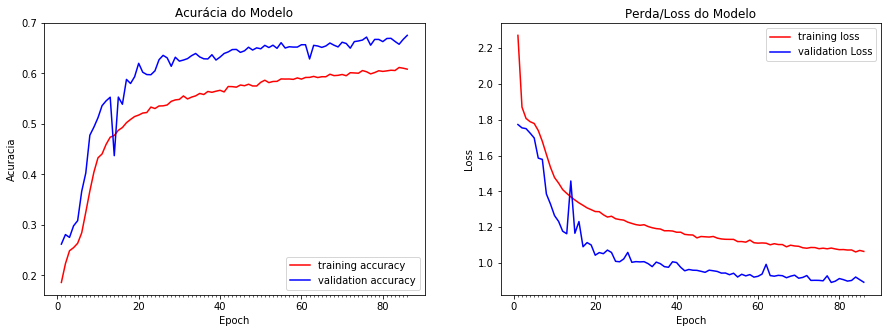

In [ ]:
#Gráfico de como o modelo se comportou utilizando os dados de treino e de teste
def plota_historico_modelo(historico_modelo):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(historico_modelo.history['accuracy'])+1),
                historico_modelo.history['accuracy'],'r')
    axs[0].plot(range(1,len(historico_modelo.history['val_accuracy'])+1),
                historico_modelo.history['val_accuracy'],'b')
    axs[0].set_title('Acurácia do Modelo')
    axs[0].set_ylabel('Acuracia')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(historico_modelo.history['accuracy'])+1),
                      len(historico_modelo.history['accuracy'])/10)
    axs[0].legend(['training accuracy', 'validation accuracy'], loc='best')

    axs[1].plot(range(1,len(historico_modelo.history['loss'])+1),
                historico_modelo.history['loss'],'r')
    axs[1].plot(range(1,len(historico_modelo.history['val_loss'])+1),
                historico_modelo.history['val_loss'],'b')
    axs[1].set_title('Perda/Loss do Modelo')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(historico_modelo.history['loss'])+1),
                      len(historico_modelo.history['loss'])/10)
    axs[1].legend(['training loss', 'validation Loss'], loc='best')
    fig.savefig('historico_modelo_mod01.png')
    plt.show()

plota_historico_modelo(history)

### Verificando a acurácia do modelo

In [ ]:
scores = model.evaluate(np.array(x_test), np.array(y_test), batch_size=batch_size)
print("Acurácia: " + str(scores[1]))
print("Perda/Loss: " + str(scores[0]))

3589/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

## Carregaremos os dados para gerar a matriz de confusão

In [ ]:
#Carrega o modelo utiliza-o para fazer previsões em um conjunto de teste, calcula a acurácia comparando os resultados com os valores reais e, por fim, salva as previsões.

true_y=[]
pred_y=[]
x = np.load('mod_xtest.npy')
y = np.load('mod_ytest.npy')
json_file = open(arquivo_modelo_json, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights(arquivo_modelo)
y_pred= loaded_model.predict(x)
yp = y_pred.tolist()
yt = y.tolist()
count = 0
for i in range(len(y)):
    yy = max(yp[i])
    yyt = max(yt[i])
    pred_y.append(yp[i].index(yy))
    true_y.append(yt[i].index(yyt))
    if(yp[i].index(yy)== yt[i].index(yyt)):
        count+=1
acc = (count/len(y))*100
np.save('truey__mod02', true_y)
np.save('predy__mod02', pred_y)
print("Acurácia no conjunto de testes: "+str(acc)+"%")

Acurácia no conjunto de testes: 66.53663973251602%


## Gerando a Matriz de Confusão

In [ ]:
#Gera a matriz de confusão com os dados obtidos
from sklearn.metrics import confusion_matrix
y_true = np.load('truey__mod02.npy')
y_pred = np.load('predy__mod02.npy')
cm = confusion_matrix(y_true, y_pred)
expressoes = ["Raiva", "Nojo", "Medo", "Feliz", "Triste", "Surpreso", "Neutro"]
titulo='Matriz de Confusão'
print(cm)

[[304   0  32  16  41  20  85]
 [ 28   8   5   0   7   2   2]
 [ 67   2 195  13 125  81  62]
 [ 16   0   7 785  15  18  40]
 [ 53   1  36  14 307   6 171]
 [  9   0  24  33   8 320  20]
 [ 25   0   8  30  67  12 469]]


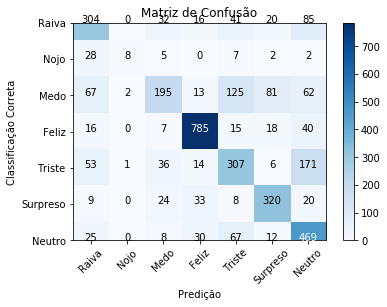

In [ ]:
#Geração do gráfico da matriz de confusão
import itertools
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(titulo)
plt.colorbar()
tick_marks = np.arange(len(expressoes))
plt.xticks(tick_marks, expressoes, rotation=45)
plt.yticks(tick_marks, expressoes)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Classificação Correta')
plt.xlabel('Predição')
#plt.savefig(diretorio + 'matriz_confusao_mod05__dataaug.png')
plt.show()

## Testando brevemente o modelo

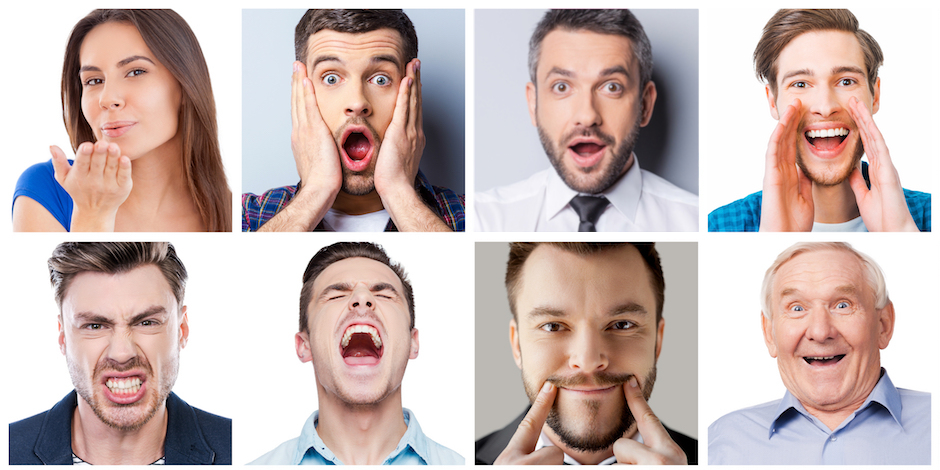

In [ ]:
#Carregamento das imagens de teste
imagem = cv2.imread(diretorio + "testes/teste03.jpg")
cv2_imshow(imagem)

In [ ]:
#Carregamento do modelo
model = load_model(diretorio + "modelo_02_expressoes_dataaug.h5")
scores = model.evaluate(np.array(x_test), np.array(y_test), batch_size=batch_size)
print("Perda/Loss: " + str(scores[0]))
print("Acurácia: " + str(scores[1]))

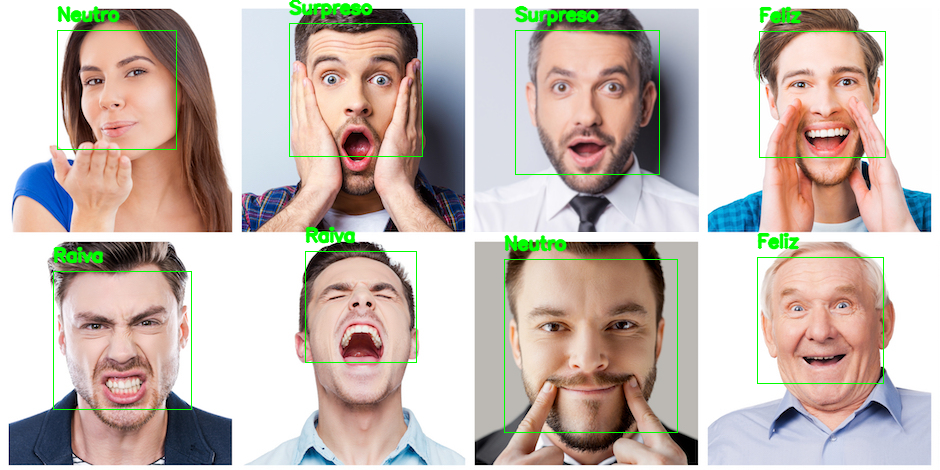

In [ ]:
#Geração do roi e da previsão de cada um dos rostos
expressoes = ["Raiva", "Nojo", "Medo", "Feliz", "Triste", "Surpreso", "Neutro"]
original = imagem.copy()
gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
face_cascade = cv2.CascadeClassifier(diretorio+'haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(gray, 1.1, 3)
for (x, y, w, h) in faces:
    cv2.rectangle(original, (x, y), (x + w, y + h), (0, 255, 0), 1)
    roi_gray = gray[y:y + h, x:x + w]
    roi_gray = roi_gray.astype("float") / 255.0
    cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
    cv2.normalize(cropped_img, cropped_img, alpha=0, beta=1,
                  norm_type=cv2.NORM_L2, dtype=cv2.CV_32F)
    prediction = model.predict(cropped_img)[0]
    cv2.putText(original, expressoes[int(np.argmax(prediction))], (x, y - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2, cv2.LINE_AA)
cv2_imshow(original)